In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available else 'cpu'

trans = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


BATCH_SIZE = 128


classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=trans)
train_loader1 = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


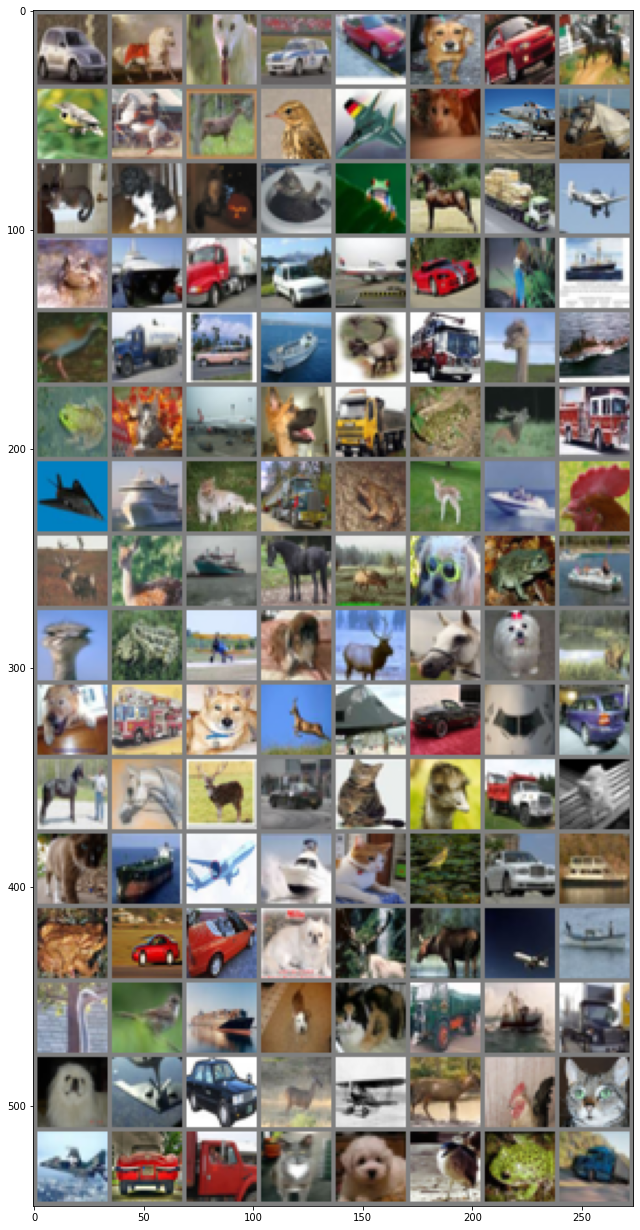

car   horse dog   car   car   dog   car   horse bird  horse deer  bird  plane cat   plane horse cat   dog   cat   cat   frog  horse truck plane frog  ship  truck car   plane car   bird  ship  bird  truck car   ship  deer  truck bird  ship  frog  cat   plane dog   truck frog  deer  truck plane ship  cat   truck frog  deer  ship  bird  deer  deer  ship  horse deer  dog   frog  ship  bird  frog  plane dog   deer  horse dog   deer  dog   truck dog   deer  plane car   plane car   horse horse deer  car   cat   bird  truck cat   cat   ship  plane ship  cat   bird  car   ship  frog  car   car   dog   deer  deer  plane ship  bird  bird  ship  dog   cat   truck ship  truck dog   plane car   deer  plane deer  bird  cat   plane car   truck cat   dog   bird  frog  truck


In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(22,22))

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader1)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [3]:
siamese = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Flatten(),
    nn.Linear(256, 128)
).to(device)

In [ ]:
cos = nn.CosineSimilarity(dim=1)
bce = nn.BCELoss()
EPOCH = 300

optim = torch.optim.Adam(siamese.parameters(), lr = 0.01)

loss_values = []
for epoch in range(EPOCH):
    iter2 = iter(train_loader2)
    for i, (x1, labels1) in enumerate(train_loader1):
        try:
            (x2, labels2) = next(iter2)
        except StopIteration:
            iter2 = iter(train_loader2)
            (x2, labels2) = next(iter2)
        
        x1_embed = siamese(x1.to(device))
        x2_embed = siamese(x2.to(device))
        y = torch.tensor([1 if a == b else 0 for a, b in zip(labels1, labels2)], dtype=torch.float).to(device)
        
        cost = bce((cos(x1_embed,x2_embed)+1)/2, y)
        
        optim.zero_grad()
        cost.backward()
        optim.step()
        
    loss_values.append(cost.item())

In [ ]:
vector = []
labels = []
for x, label in train_loader1:
    for vec in siamese(x.to(device)):
        vector.append(vec.tolist())
    labels += label.tolist()

In [52]:
import heapq
import tqdm
import random

def cosine(a, b):
    return (a * b).sum() / (((a * a).sum() * (b * b).sum()) ** 0.5)

N = len(vector)
K = 30
V = np.array(vector)
tests = 10

for idx in np.random.permutation(N)[:tests]:
    result = []
    hq = []
    for i in range(N):
        dist = -(cosine(V[idx], V[i])+1)/2
        heapq.heappush(hq, (dist, i))
    heapq.heappop(hq)
    for _ in range(K):
        dist, i = heapq.heappop(hq)
        result.append(i)
    print(labels[idx], sum(int(labels[idx] == labels[v]) for v in result))

3 17
4 30
2 30
1 30
6 30
6 30
9 30
5 2
5 29
9 30
